In [2]:
from os import listdir
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage as ski
from skimage import data, color, filters, io, feature, measure, draw
import cv2
import colorsys
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import skimage.morphology as mp

In [40]:

def list_image(dir_path="images/", mask_path="mask/"):
    photo_list = []
    # for i in range(1, 62):
    #     photoList.append(str(i) + '.jpg')
    photo_list.append("01_g")
    # print(photoList)
    # return [os.path.join(dir_path, file) for file in ['1.jpg']]
    return [[os.path.join(dir_path, file+".jpg"),os.path.join(mask_path, file+"_mask.tif")]  for file in photo_list]

def input_data(image_path, mask_path):
    return [cv2.imread(image_path, cv2.IMREAD_COLOR),cv2.imread(mask_path, cv2.IMREAD_COLOR)]

def extract_green_channel(image):
    b, g, r = cv2.split(image)
    return g

def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

def aply_mask(image, mask):
    _,mask,_ = cv2.split(mask)
    return cv2.bitwise_and(image, mask)

def prepare_image(image,mask):
    prepared_image = extract_green_channel(image)
    print_partial_result(prepared_image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    veins_extracted_image = clahe.apply(prepared_image)
    print_partial_result(veins_extracted_image)
    prepared_image = morphology(prepared_image, 5)
    prepared_image = morphology(prepared_image, 13)
    prepared_image = morphology(prepared_image, 27)   
    prepared_image = cv2.subtract(veins_extracted_image, prepared_image)
    prepared_image = clahe.apply(prepared_image)

    print_partial_result(prepared_image)   
    prepared_image = aply_mask(prepared_image,mask)
    print_partial_result(prepared_image)   
    ret, prepared_image_cp = cv2.threshold(
        prepared_image, 15, 255, cv2.THRESH_BINARY)
    print_partial_result(prepared_image)

    noise_mask = np.ones(prepared_image.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(prepared_image_cp.copy(), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(noise_mask, [cnt], -1, 0, -1)
    prepared_image = cv2.bitwise_and(prepared_image, prepared_image, mask=noise_mask)
    ret, prepared_image = cv2.threshold(prepared_image, 15, 255, cv2.THRESH_BINARY_INV)
    prepared_image = cv2.erode(prepared_image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)),iterations=1)
    prepared_image = cv2.bitwise_not(prepared_image)
 
    print_partial_result(prepared_image)

    another_mask = np.ones(image.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(prepared_image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
        if len(approx) > 4 and 3000 >= cv2.contourArea(cnt) >= 100:
            cv2.drawContours(another_mask, [cnt], -1, 0, -1)
    prepared_image = cv2.bitwise_and(prepared_image, fundus_eroded, mask=another_mask)
    print_partial_result(prepared_image)

    return prepared_image

#    print_partial_result(image)


def morphology(img, radius):
    o1 = cv2.morphologyEx(img, cv2.MORPH_OPEN,
                          cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)), iterations=1)
    return cv2.morphologyEx(o1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)),
                            iterations=1)


def print_partial_result(image):
    plt.figure()
    io.imshow(image)
    plt.show()


def imagePart(image, coordinates):
    partList = []
    for coord in coordinates:
        if abs(coord[3]-coord[2]) > 40 and abs(coord[1] - coord[0]) > 40:
            partList.append(image[coord[2]: coord[3], coord[0]: coord[1]])

    plt.imshow(image, cmap="Greys_r")
    #plt.savefig("pho/test" + str(i+1) + ".jpg", bbox_inches="tight")
    j = 0
    for item in partList:
        # print_partial_result(item)
        plt.imshow(item, cmap="Greys_r")
        # plt.savefig("pho/test" + str(i+1) + "sub" +
        # str(j) + ".jpg", bbox_inches="tight")
        j = j + 1
    return partList

# MJ
# [[],[],[]...], [x,y]


def boardArea(contours, size):
    contoursNode = []

    for con in contours:
        lewo = size[0]
        prawo = 0
        gora = 0
        dol = size[1]
        for pixel in con:
            p = pixel[0]
            if(p[0] > prawo):
                prawo = p[0]
            if(p[0] < lewo):
                lewo = p[0]
            if(p[1] > gora):
                gora = p[1]
            if(p[1] < dol):
                dol = p[1]
        contoursNode.append((lewo, prawo, dol, gora))
    return contoursNode




[['images/01_g.jpg', 'mask/01_g_mask.tif']]


<Figure size 432x288 with 0 Axes>

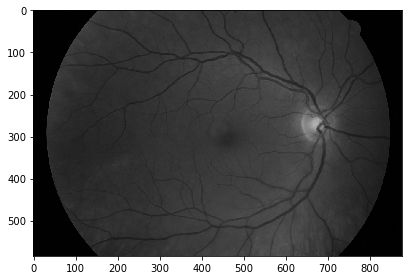

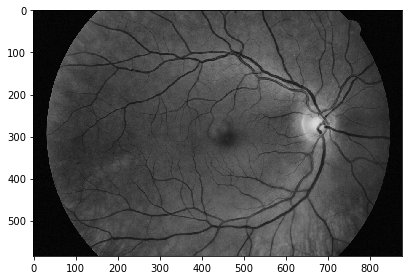

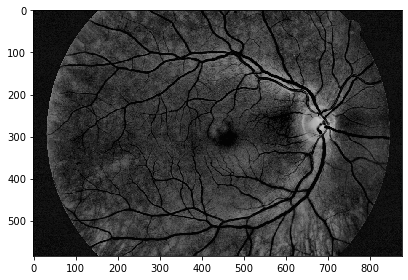

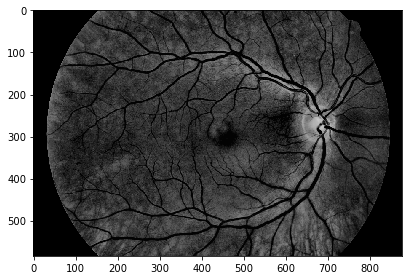

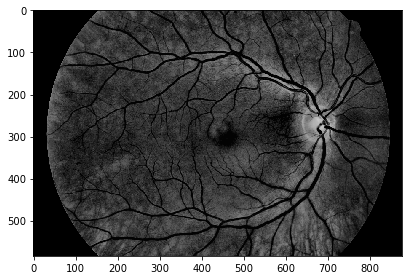

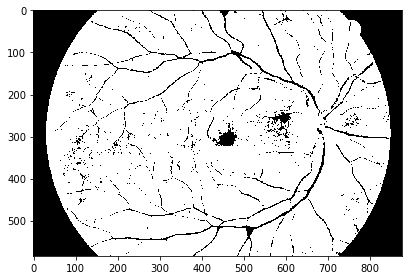

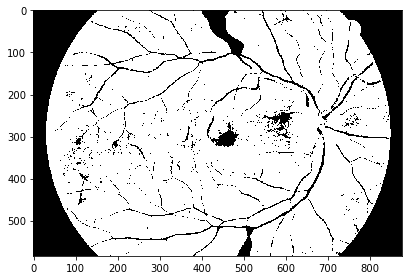

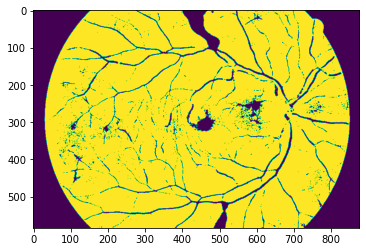

In [41]:
if __name__ == "__main__":
    # plt.figure(figsize=(20, 10))
    # plt.subplots_adjust(left=0, bottom=0, right=0.985, hspace=0, wspace=0)
    plt.figure()
    print(list_image())
    for i, [image_path, mask_path] in enumerate(list_image()):
        [image,mask] = input_data(image_path,mask_path)

        image = cv2.resize(
            image, (int(image.shape[1]/4), int(image.shape[0]/4)))
        mask = cv2.resize(
            mask, (int(mask.shape[1]/4), int(mask.shape[0]/4)))       
       
        image = prepare_image(image, mask)

        plt.imshow(image)
        plt.show()


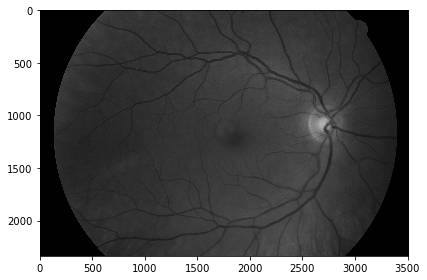

UnboundLocalError: local variable 'prepared_image' referenced before assignment

In [34]:
import cv2
import numpy as np

def print_partial_result(image):
    plt.figure()
    io.imshow(image)
    plt.show()

def list_image(dir_path="images/", mask_path="mask/"):
    image_list = []
    image_list.append("01_g")
    image_paths =  [os.path.join(dir_path, file+".jpg") for file in image_list]
    return [cv2.imread(image_path, cv2.IMREAD_COLOR)for image_path in image_paths]

def prepare_image(image):
    b, image, r = cv2.split(image)
    print_partial_result(image)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    prepared_image = clahe.apply(image)
    background = morphology(prepared_image, 5)
    background = morphology(background, 15)
    background = morphology(background, 25)
    prepared_image = cv2.subtract(background, prepared_image)
    prepared_image = clahe.apply(prepared_image)
    print_partial_result(prepared_image)

    prepared_image = remove_noise(prepared_image)
    print_partial_result(prepared_image)
    pass

def remove_noise(image):
    _, transformed_image = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
    contours, _ = cv2.findContours(transformed_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    image = cv2.bitwise_and(image, mask)
    _, image = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)
    image = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=1)
    return image

def morphology(image, radius):
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN,
                          cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)), iterations=1)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius)),
 iterations=1)

if __name__ == '__main__':
    for i,image in enumerate(list_image()): 
        prepare_image(image)
